In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore # z score is used to check outliers.


In [29]:
airline = pd.read_csv("air-passenger.csv")

In [30]:
airline

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [31]:
airline.shape

(144, 2)

In [32]:
airline.columns = ['Date','passengers']

In [33]:
airline.head()

,Date,passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [34]:
# Convert Date to datetime and set index
airline['Date'] = pd.to_datetime(airline['Date'])
airline.set_index('Date', inplace = True)

In [35]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [36]:
# Checking for missing values
print(airline.isnull().sum())

passengers    0
dtype: int64


No Null Value.

If there were missing values  we can fill that by using fillna(method = 'ffill') forward fill

In [37]:
#Detect Outliers using z-score
airline['z_score'] = zscore(airline['passengers'])

In [38]:
#Remove outliers beyond (positive/negative 3)
airline = airline[airline['z_score'].abs()<3]

In [39]:
airline.head()

,passengers,z_score
Date,,
1949-01-01,112,-1.407779
1949-02-01,118,-1.357590
1949-03-01,132,-1.240483
1949-04-01,129,-1.265578
1949-05-01,121,-1.332496


In [40]:
airline.shape

(144, 2)

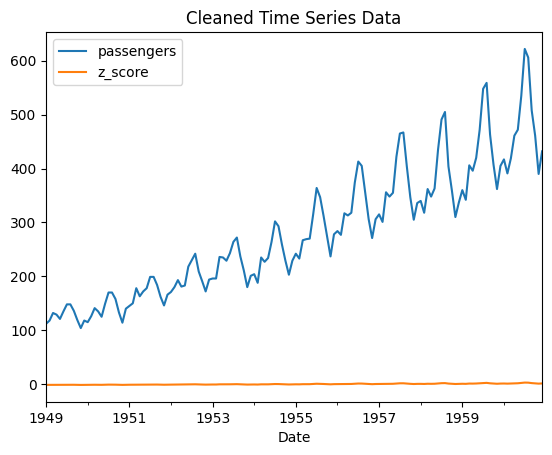

In [41]:
#Plot the cleaned data
airline.plot(title = 'Cleaned Time Series Data')
plt.show()

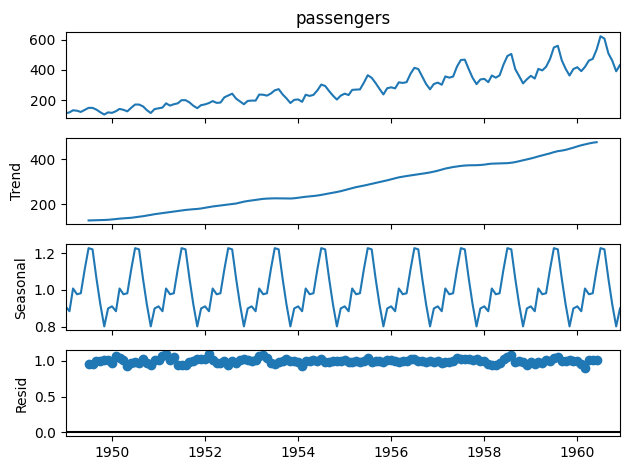

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

#Multiplicative decompose (for seasonal data)
result = seasonal_decompose(airline['passengers'], model='multiplicative', period=12)
# Plot decomposition
result.plot()
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


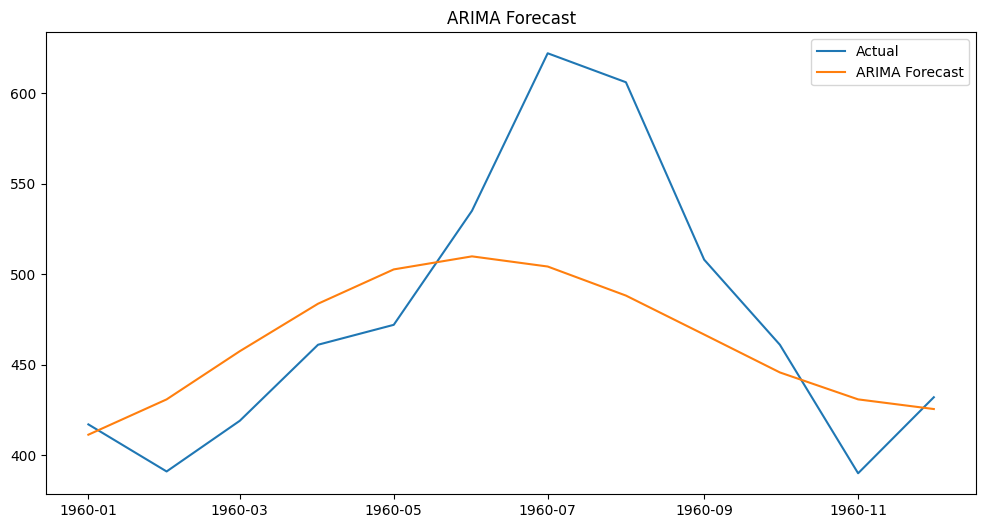

In [43]:
from statsmodels.tsa.arima.model import ARIMA
#train-test split
train = airline.iloc[:-12]
test = airline.iloc[-12:]

#fit ARIMA  model
model_arima = ARIMA(train['passengers'], order=(2, 1, 2))
model_arima_fit = model_arima.fit()

# Forcast next 12 months
forecast_arima = model_arima_fit.forecast(steps=12)

#plot
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['passengers'], label='Actual')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast')
plt.legend()
plt.title('ARIMA Forecast')
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


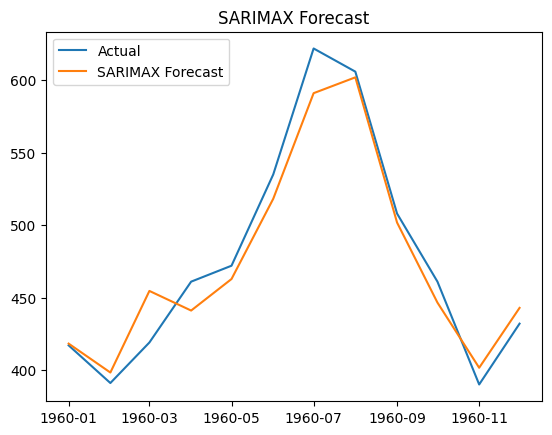

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
#train-test split
train = airline.iloc[:-12]
test = airline.iloc[-12:]


#Fit Arima model
model_sarimax = SARIMAX(train['passengers'], order=(2, 1, 2),seasonal_order=(1, 1, 1, 12))
model_sarimax_fit = model_sarimax.fit()

# Forcast next 12 months
forecast_sarimax = model_sarimax_fit.forecast(steps=12)

#Plot
plt.plot(test.index, test['passengers'], label='Actual')
plt.plot(test.index, forecast_sarimax, label='SARIMAX Forecast')
plt.legend()
plt.title('SARIMAX Forecast')
plt.show()

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8smd_nr0/jr8_e5t4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8smd_nr0/toupormv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97329', 'data', 'file=/tmp/tmp8smd_nr0/jr8_e5t4.json', 'init=/tmp/tmp8smd_nr0/toupormv.json', 'output', 'file=/tmp/tmp8smd_nr0/prophet_modelbpsvapll/prophet_model-20251021130012.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:00:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:00:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/

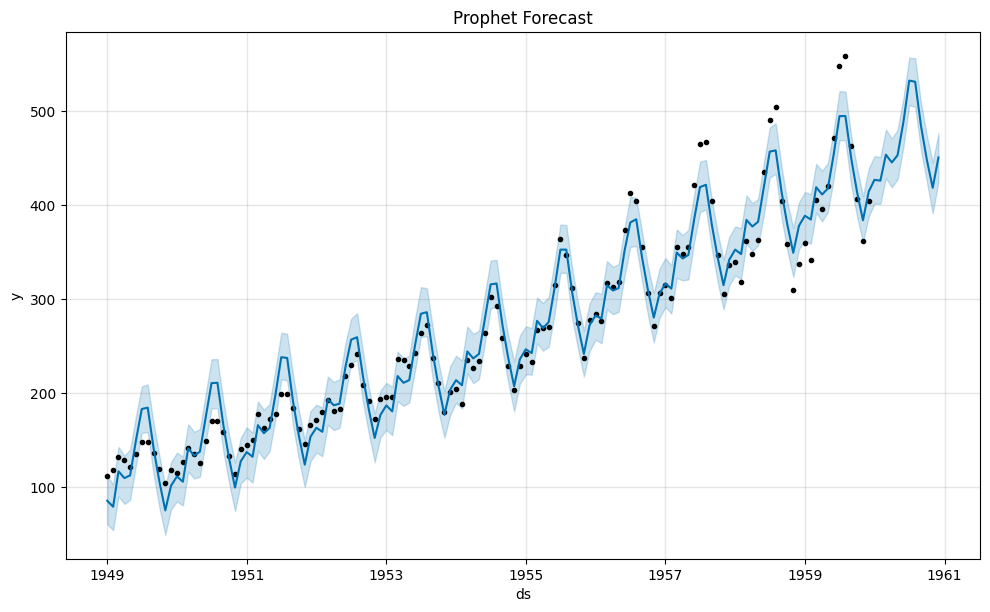

In [46]:
from prophet import Prophet
import matplotlib.pyplot as plt

#Prepare data for Prophet
airline_prophet = airline.reset_index().rename(columns= {'Date':'ds','passengers':'y'})
train_prophet = airline_prophet.iloc[:-12]
#Fit model
model_prophet = Prophet()
model_prophet.fit(train_prophet)
#Create future dataframe
future = model_prophet.make_future_dataframe(periods=12, freq='M')
#Make prediction
forecast_prophet = model_prophet.predict(future)

#Plot forecast
model_prophet.plot(forecast_prophet)
plt.title('Prophet Forecast')
plt.show()



In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
#Actual test values
y_true = test['passengers'].values

# Prophet predictions
y_pred_prophet = forecast_prophet.iloc[-12:]['yhat'].values

#Evaluate function
def evaluate(y_true, y_pred,model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MAE: {mae:.2f},RMSE:{rmse:.2f}")

# Run evaluations
evaluate(y_true,forecast_arima.values,"ARIMA")
evaluate(y_true,forecast_sarimax.values,"SARIMAX")
evaluate(y_true,y_pred_prophet,"Prophet")

ARIMA - MAE: 41.83,RMSE:55.22
SARIMAX - MAE: 13.99,RMSE:17.21
Prophet - MAE: 33.98,RMSE:41.51
